In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.steps)
print len(storage.cvs)

1001
1


In [3]:
%%time
storage.samples.cache_all()
storage.samplesets.cache_all()
storage.pathmovechanges.cache_all()
storage.steps.cache_all()
map(lambda x : x.cache_all(storage), storage.cvs)

CPU times: user 1.93 s, sys: 316 ms, total: 2.24 s
Wall time: 2.2 s


In [4]:
retis = storage.transitions.load(0)
retis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
retis.rate(storage)

0.00016877560759032177

In [6]:
%%time
print retis.conditional_transition_probability(storage, retis.ensembles[-1])

0.742257742258
CPU times: user 40.4 ms, sys: 11.3 ms, total: 51.7 ms
Wall time: 44 ms


In [7]:
retis.all_statistics(storage, force=True)

In [8]:
retis.total_crossing_probability(storage=storage)

In [9]:
print retis.minus_move_flux(storage=storage)

0.010864504113


In [10]:
%%time
scheme = paths.MoveScheme(retis)
scheme.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 2 ran 6.59340659341% of the cycles with acceptance 50/66 (0.757575757576) 
OneWayShootingMover I'face 4 ran 8.89110889111% of the cycles with acceptance 59/89 (0.662921348315) 
OneWayShootingMover I'face 1 ran 9.09090909091% of the cycles with acceptance 76/91 (0.835164835165) 
OneWayShootingMover I'face 5 ran 6.19380619381% of the cycles with acceptance 43/62 (0.693548387097) 
OneWayShootingMover I'face 0 ran 8.69130869131% of the cycles with acceptance 63/87 (0.724137931034) 
OneWayShootingMover I'face 3 ran 8.79120879121% of the cycles with acceptance 64/88 (0.727272727273) 

CPU times: user 150 ms, sys: 37.1 ms, total: 187 ms
Wall time: 160 ms


In [11]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 2 ran 6.59340659341% of the cycles with acceptance 50/66 (0.757575757576) 
OneWayShootingMover I'face 4 ran 8.89110889111% of the cycles with acceptance 59/89 (0.662921348315) 
OneWayShootingMover I'face 1 ran 9.09090909091% of the cycles with acceptance 76/91 (0.835164835165) 
OneWayShootingMover I'face 5 ran 6.19380619381% of the cycles with acceptance 43/62 (0.693548387097) 
OneWayShootingMover I'face 0 ran 8.69130869131% of the cycles with acceptance 63/87 (0.724137931034) 
OneWayShootingMover I'face 3 ran 8.79120879121% of the cycles with acceptance 64/88 (0.727272727273) 


In [12]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [13]:
first40 = first_n(storage, 40, trajid=4)

In [14]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

AttributeError: 'super' object has no attribute '_Details__ini'

In [15]:
SVG(view.to_svg())

NameError: name 'view' is not defined

In [15]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 15 decorrelated trajectories.


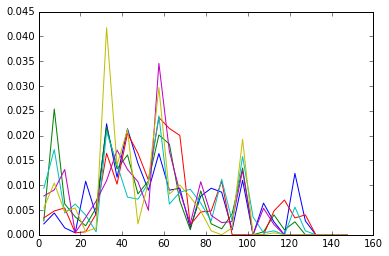

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    normalized = myhist.normalized()
    plt.plot(normalized.x, normalized)

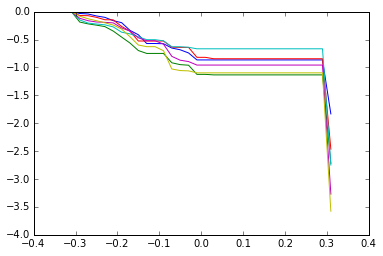

In [17]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    reverse_cumulative = myhist.reverse_cumulative()
    plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))


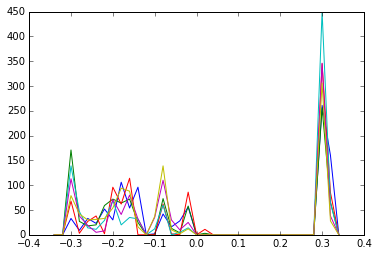

In [18]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]()
    plt.plot(myhist.x, myhist)

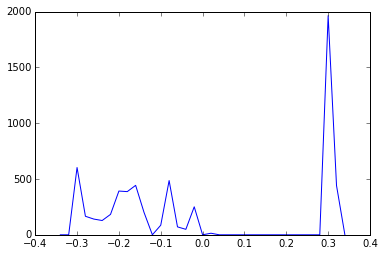

In [19]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.x, total_sampling);

In [20]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

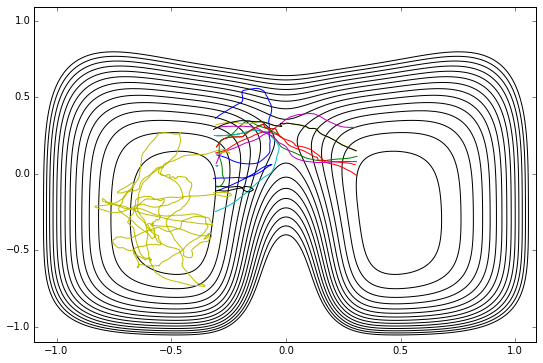

In [21]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

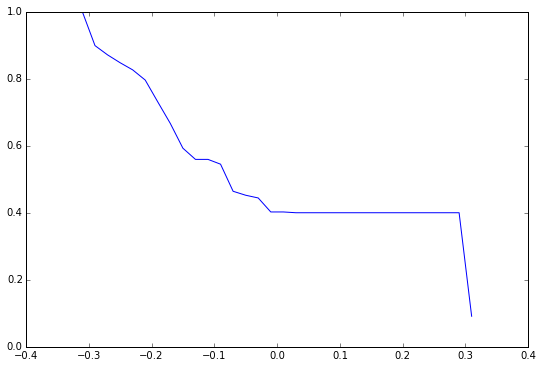

In [22]:
wham = retis.total_crossing_probability(method="wham")
plt.plot(wham.x, wham);

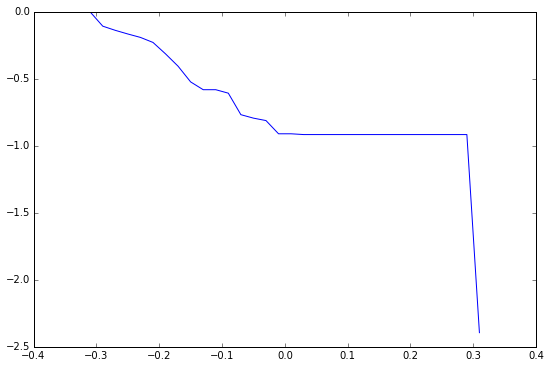

In [23]:
plt.plot(wham.x, np.log(wham));

In [24]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 46.5 ms, sys: 13.6 ms, total: 60.1 ms
Wall time: 50 ms


0.23476523476523475

In [25]:
retis.minus_move_flux(storage)

nan

In [26]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

nan 0.452713952714 0.234765234765


In [27]:
retis.rate(storage)

nan

Note that, with insufficient data, the guess for the location of the outermost interface can be incorrect. If you specify the `outer_lambda`, you'll get a different answer.

In [28]:
retis.rate(storage, outer_lambda=-0.05)

nan

In [29]:
print retis._flux * retis.tcp(-0.05) * retis.ctp[retis.ensembles[-1]]

nan
